In [98]:
import numpy as np
from matplotlib import pyplot as plt
from io import StringIO
import pandas as pd
from matplotlib.pyplot import cm


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
tabular_str = """\
	basic conv	resnet18	resnet50	convnext base	swinv2	vit small	vit tiny
bigearthnet	0.3957 ± 0.0127	0.6031 ± 0.0008	0.5418 ± 0.0039	0.607 ± 0.0041	0.619 ± 0.0041	0.6185 ± 0.0007	0.6329 ± 0.0052
brick kiln	0.9257 ± 0.0104	0.9703 ± 0.0012	0.9517 ± 0.004	0.9627 ± 0.0051	0.9733 ± 0.0021	0.9663 ± 0.0021	0.9667 ± 0.0065
eurosat	0.8403 ± 0.0133	0.9207 ± 0.0058	0.9327 ± 0.0117	0.9593 ± 0.0035	0.9693 ± 0.0029	0.9543 ± 0.0023	0.957 ± 0.0017
pv4ger	0.8571 ± 0.004	0.9292 ± 0.0069	0.9404 ± 0.0114	0.9302 ± 0.0028	0.946 ± 0.0016	0.9455 ± 0.0037	0.9381 ± 0.0098
so2sat	0.2566 ± 0.011	0.4209 ± 0.001	0.4128 ± 0.0372	0.4834 ± 0.002	0.4966 ± 0.0198	0.5112 ± 0.0146	0.4635 ± 0.0306"""

In [105]:
def get_mean(val):
    if "±" in val:
        return float(val.split("±")[0])
    else:
        return val

def get_std(val):
    if "±" in val:
        return float(val.split("±")[1])
    else:
        return val

df = pd.read_csv(StringIO(tabular_str), sep='\t', index_col=0)
df_mean = df.applymap(get_mean)
df_std = df.applymap(get_std)


df_mean


,basic conv,resnet18,resnet50,convnext base,swinv2,vit small,vit tiny
bigearthnet,0.3957,0.6031,0.5418,0.6070,0.6190,0.6185,0.6329
brick kiln,0.9257,0.9703,0.9517,0.9627,0.9733,0.9663,0.9667
eurosat,0.8403,0.9207,0.9327,0.9593,0.9693,0.9543,0.9570
pv4ger,0.8571,0.9292,0.9404,0.9302,0.9460,0.9455,0.9381
so2sat,0.2566,0.4209,0.4128,0.4834,0.4966,0.5112,0.4635


In [106]:
class Normalizer:

    def __init__(self, df_mean, df_std, border=0.1):
        self.border = border
        self.range_dict = {}
        df_mean_t = df_mean.transpose()
        df_std_t = df_std.transpose()
        for ds_name in df_mean_t:
            mean = df_mean_t[ds_name].to_numpy()
            std = df_std_t[ds_name].to_numpy()

            self.range_dict[ds_name] = (min(mean-std), max(mean+std))
    
    def __call__(self, ds_name, values, scale_only=False):
        mn, mx = self.range_dict[ds_name]
        range = mx-mn
        if scale_only:
            return values / range
        else:
            return (values - mn)/range

    def from_row(self, row, scale_only=False):
        return [self(ds_name, val, scale_only=scale_only) for ds_name, val in row.items()]
        
        


basic conv
resnet18
resnet50
convnext base
swinv2
vit small
vit tiny


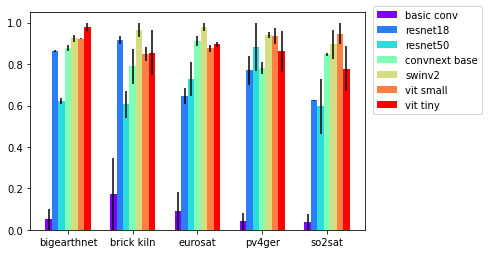

In [107]:
colors = cm.rainbow(np.linspace(0, 1, 7))

normalizer = Normalizer(df_mean, df_std)
for i, backbone in enumerate(df_mean):
    print(backbone)
    ds_names = df_mean[backbone].keys()
    mean = normalizer.from_row(df_mean[backbone])
    err = normalizer.from_row(df_std[backbone], scale_only=True)
    x = np.arange(len(mean)) + i/10 

    if i == 3:
        plt.bar(x, mean, width=0.1, label=backbone, yerr=err,tick_label=ds_names)
    else:
        plt.bar(x, mean, width=0.1, label=backbone, yerr=err, )
plt.legend(bbox_to_anchor=(1.01, 1.05))